# Power Data EDA for MIE1628 Cloud Data Analytics Project

In [1]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import geopandas as gpd
import random
from datetime import datetime, timedelta

import re
import io
from copy import deepcopy
#from tqdm import tqdm
import tqdm.notebook as tq

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Import data

Import time-series data in loop and append

### Demand 2018-2023

In [2]:
demand = []
for x in range(2018,2024):
    print(x)
    dem_x = pd.read_csv('demand_data_hourly/PUB_Demand_{}.csv'.format(x), header=3, index_col=0)   
    dem_x.index = pd.DatetimeIndex(dem_x.index) + pd.to_timedelta(dem_x['Hour'], unit='h')
    demand.append(dem_x)

demand_t = pd.concat(demand)
print(demand_t.shape)
demand_t.head()

2018
2019
2020
2021
2022
2023
(51576, 3)


,Hour,Market Demand,Ontario Demand
2018-01-01 01:00:00,1,18974,16627
2018-01-01 02:00:00,2,18447,16084
2018-01-01 03:00:00,3,18453,15866
2018-01-01 04:00:00,4,18662,15725
2018-01-01 05:00:00,5,18060,15470


In [3]:
demand_t[datetime(2021,1,1,0):datetime(2021,1,1,5)]

,Hour,Market Demand,Ontario Demand
2021-01-01 00:00:00,24,16723,14665
2021-01-01 01:00:00,1,16057,14112
2021-01-01 02:00:00,2,15516,13504
2021-01-01 03:00:00,3,15185,13155
2021-01-01 04:00:00,4,14940,12892
2021-01-01 05:00:00,5,14802,12798


<AxesSubplot:ylabel='Market Demand'>

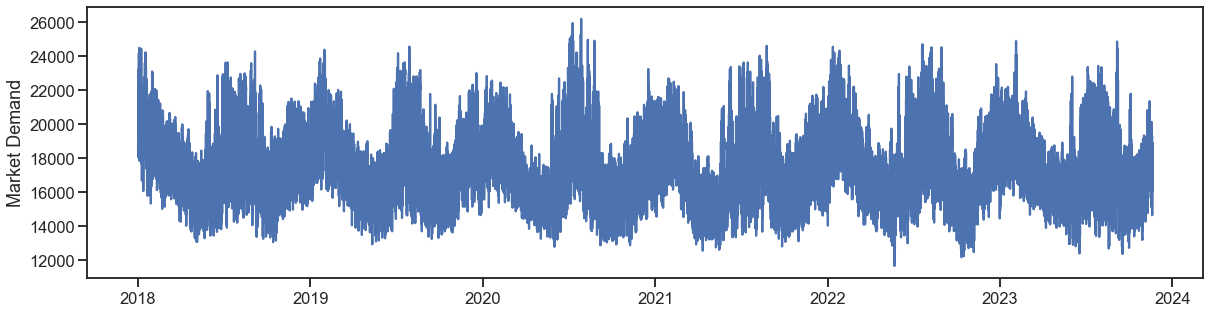

In [4]:
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=demand_t, y='Market Demand', x=demand_t.index, ax=ax)

In [5]:
# plot every day in 2021
#fig, ax_n = plt.subplots(figsize=(15,8))
year = 2021

def plt_year_dem(year, ax, times_series, y_string, x_string='Hour', color='limegreen', ylim=[0,100], ylab='Demand (MW)', statistic=np.mean):
    dem_range_l = []
    for t in (datetime(year,1,1) + timedelta(n) for n in range(365)):
        dem_range = times_series[t:t+timedelta(hours=23)]
        dem_range_l.append(dem_range)
        sns.lineplot(data=dem_range, y=y_string, x=x_string, ax=ax,
                    alpha=0.6, color='lightgrey')
        
    dem_agg = pd.concat(dem_range_l).groupby(x_string).agg(statistic)
    sns.lineplot(data=dem_agg, y=y_string, x=x_string, ax=ax,
                    alpha=1, color=color, linewidth=3)

    ax.set_title(year)
    ax.set_xlabel('Hour')
    ax.set_ylabel(ylab)
    ax.set_xlim([1,24])
    ax.set_ylim([ylim[0],ylim[1]])

#plt_year_dem(2021, ax_n, demand_t)

2018
2019
2020
2021
2022
2023


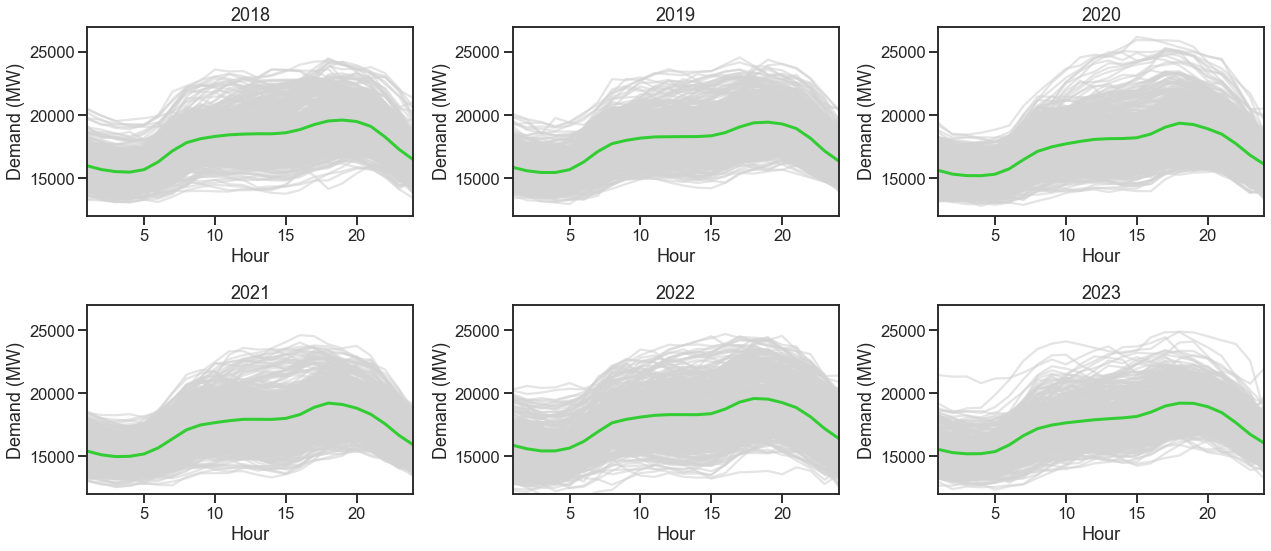

In [6]:
fig, ax = plt.subplots(2,3, figsize=(18,8))

for i, axy in enumerate(ax.reshape(-1)):
    print(i+2018)
    plt_year_dem(i+2018, axy, demand_t, 
                 y_string='Market Demand', ylim=[12000, 27000]) 

plt.tight_layout()

### Price (our target probably)

In [7]:
price = []
for x in range(2018,2024):
    print(x)
    
    price_x = pd.read_csv('price_data_y/PUB_PriceHOEPPredispOR_{}.csv'.format(x), header=3, index_col=0)   
    price_x.index = pd.DatetimeIndex(price_x.index) + pd.to_timedelta(price_x['Hour'], unit='h')
    price.append(price_x)

price_t = pd.concat(price)
print(price_t.shape)
price_t.head()

2018
2019
2020
2021
2022
2023
(51576, 8)


,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
2018-01-01 01:00:00,1,51.29,40.62,35.50,40.32,0.20,0.20,0.19
2018-01-01 02:00:00,2,43.59,40.93,40.57,30.22,0.20,0.20,0.20
2018-01-01 03:00:00,3,93.60,49.84,45.30,40.20,0.25,0.25,0.22
2018-01-01 04:00:00,4,54.78,55.60,40.04,45.30,0.20,0.20,0.20
2018-01-01 05:00:00,5,14.35,40.04,34.80,47.47,0.20,0.20,0.20


2018
2019
2020
2021
2022
2023


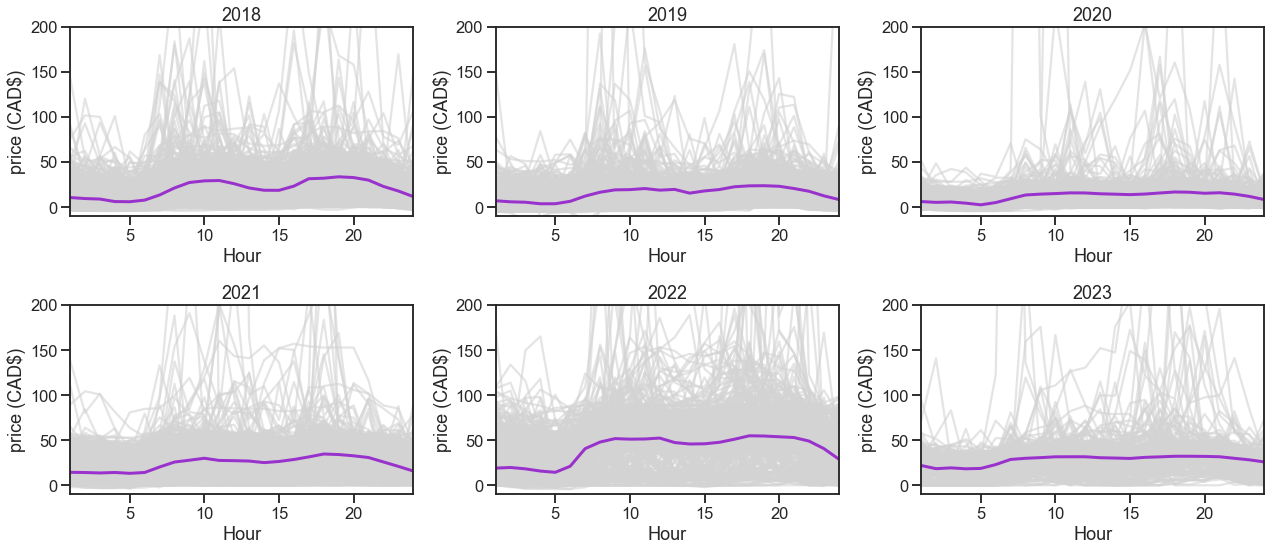

In [143]:
fig, ax = plt.subplots(2,3, figsize=(18,8))

for i, axy in enumerate(ax.reshape(-1)):
    print(i+2018)
    plt_year_dem(i+2018, axy, price_t, 
                 y_string='HOEP', ylim=[-10, 200], ylab='price (CAD$)', color='darkorchid', statistic=np.median) 

plt.tight_layout()

operating reserve market prices in $

2018
2019
2020
2021
2022
2023


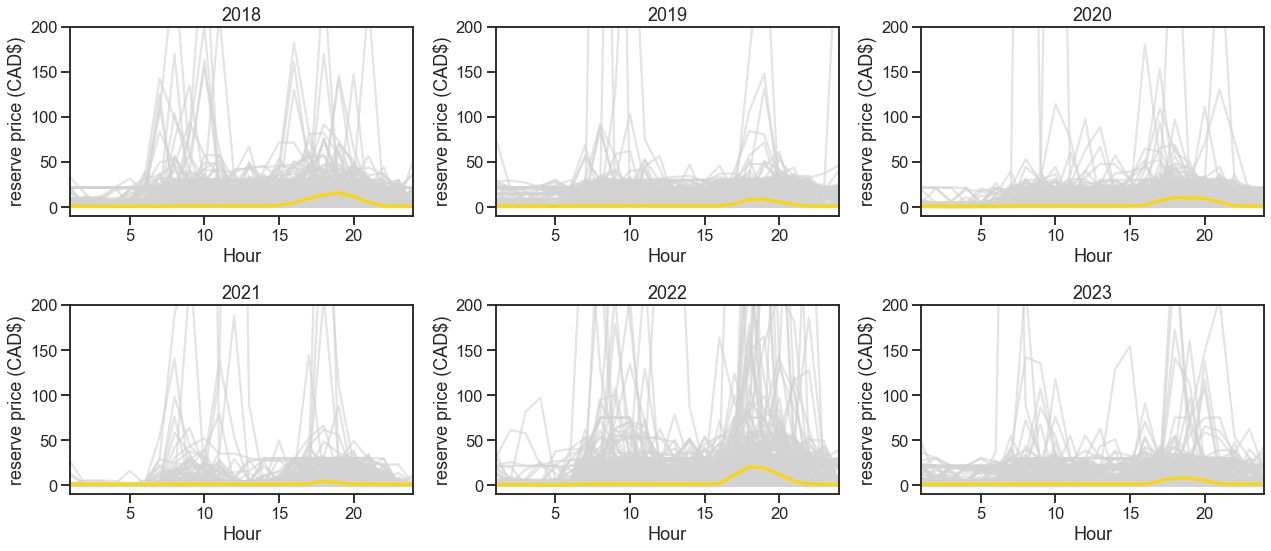

In [21]:
fig, ax = plt.subplots(2,3, figsize=(18,8))

for i, axy in enumerate(ax.reshape(-1)):
    print(i+2018)
    plt_year_dem(i+2018, axy, price_t, 
                 y_string='OR 10 Min Sync', ylim=[-10, 200], ylab='reserve price (CAD$)', color='gold', statistic=np.median) 

plt.tight_layout()

### Grid inflow outflow data

In [8]:
flow = []
for x in range(2018,2024):
    print(x)
    flow_x = pd.read_csv('flow_data/PUB_IntertieScheduleFlowYear_{}.csv'.format(x), header=4, index_col=0)   
    flow_x.index = pd.DatetimeIndex(flow_x.index) + pd.to_timedelta(flow_x['Hour'], unit='h')
    flow.append(flow_x)

flow_t = pd.concat(flow)
print(flow_t.shape)
flow_t.head()

2018
2019
2020
2021
2022
2023
(51576, 46)


,Hour,Imp,Exp,Flow,Imp.1,Exp.1,Flow.1,Imp.2,Exp.2,Flow.2,...,Flow.11,Imp.12,Exp.12,Flow.12,Imp.13,Exp.13,Flow.13,Imp.14,Exp.14,Flow.14
2018-01-01 01:00:00,1,28,42,16,0,0,8,0,900,377,...,0,0,0,69,50,0,-46,376,2394,2144
2018-01-01 02:00:00,2,28,0,-20,0,0,8,0,900,379,...,0,0,0,68,50,0,-45,242,2402,2255
2018-01-01 03:00:00,3,28,0,-26,0,0,8,0,900,392,...,0,0,0,46,50,0,-45,92,2599,2580
2018-01-01 04:00:00,4,28,0,-36,0,0,8,0,900,405,...,0,0,0,46,50,0,-45,587,3008,2594
2018-01-01 05:00:00,5,28,42,6,0,0,8,0,426,352,...,0,0,0,46,50,0,-44,265,2630,2505


2018
2019
2020
2021
2022
2023


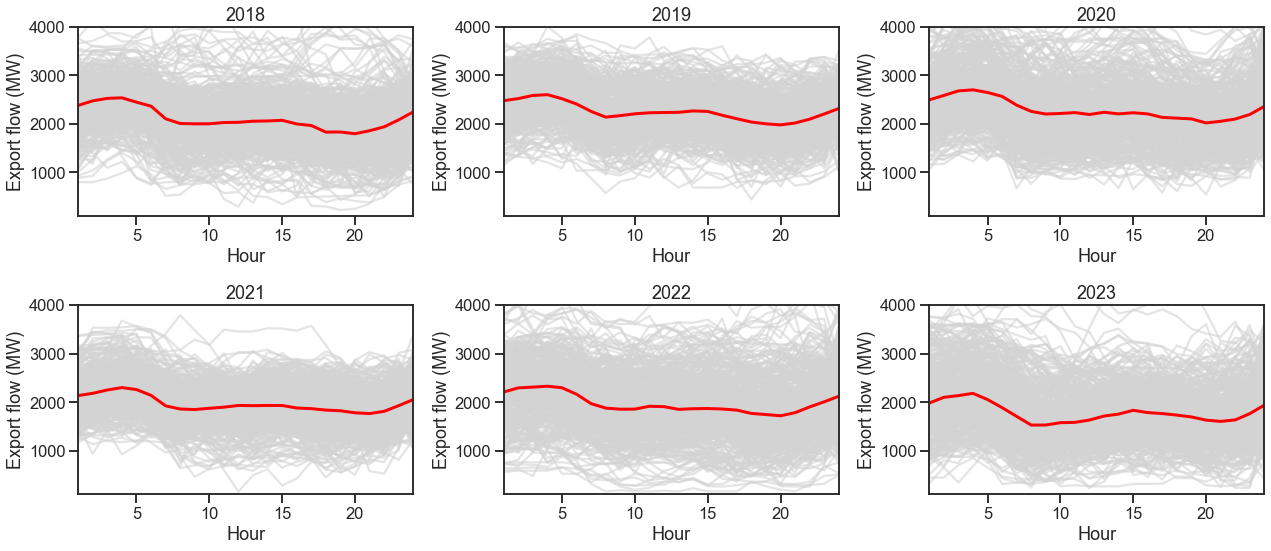

In [157]:
fig, ax = plt.subplots(2,3, figsize=(18,8))

for i, axy in enumerate(ax.reshape(-1)):
    print(i+2018)
    plt_year_dem(i+2018, axy, flow_t, 
                 y_string='Exp.14', ylim=[100, 4000], ylab='Export flow (MW)', color='red', statistic=np.median) 

plt.tight_layout()

2018
2019
2020
2021
2022
2023


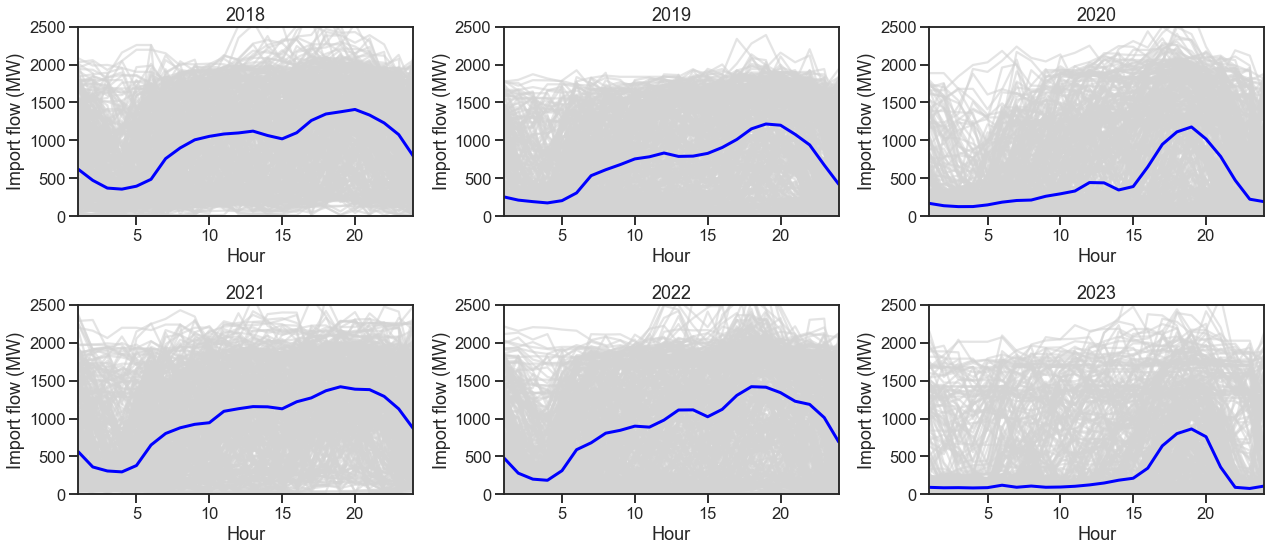

In [159]:
fig, ax = plt.subplots(2,3, figsize=(18,8))

for i, axy in enumerate(ax.reshape(-1)):
    print(i+2018)
    plt_year_dem(i+2018, axy, flow_t, 
                 y_string='Imp.14', ylim=[0, 2500], ylab='Import flow (MW)', color='blue', statistic=np.median) 

plt.tight_layout()

Many dimensions; reduce using SVD

In [160]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [171]:
# exclude total columns at end
flow_scaled = StandardScaler().fit_transform(flow_t.iloc[:,:43])
pca = PCA()
flow_pcs = pca.fit_transform(flow_scaled)

# Store
cols= ['pc{}'.format(i) for i in range(1,flow_scaled.shape[1]+1)]
flow_pcs_df = pd.DataFrame(data=flow_pcs,
                            columns=cols)

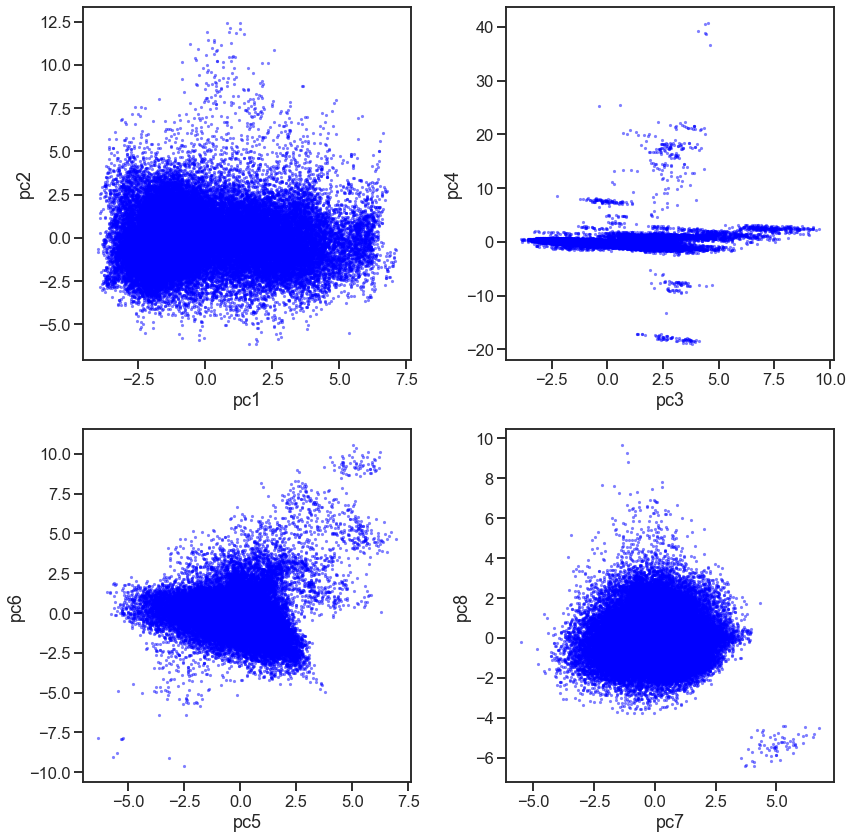

In [221]:
flow_pcs_df
fig, ax = plt.subplots(2,2, figsize=(12,12))
c = 'blue'
sns.scatterplot(ax=ax[0,0], data=flow_pcs_df, x='pc1', y='pc2', 
                alpha=0.5, s=10, linewidth=0.0, color=c,
                #hue=flow_t.reset_index()['Imp.14']
                )
sns.scatterplot(ax=ax[0,1], data=flow_pcs_df, x='pc3', y='pc4', 
                alpha=0.5, s=10, linewidth=0.0, color=c
                )
sns.scatterplot(ax=ax[1,0], data=flow_pcs_df, x='pc5', y='pc6', 
                alpha=0.5, s=10, linewidth=0.0, color=c
                )
sns.scatterplot(ax=ax[1,1], data=flow_pcs_df, x='pc7', y='pc8', 
                alpha=0.5, s=10, linewidth=0.0, color=c
                )
plt.tight_layout()

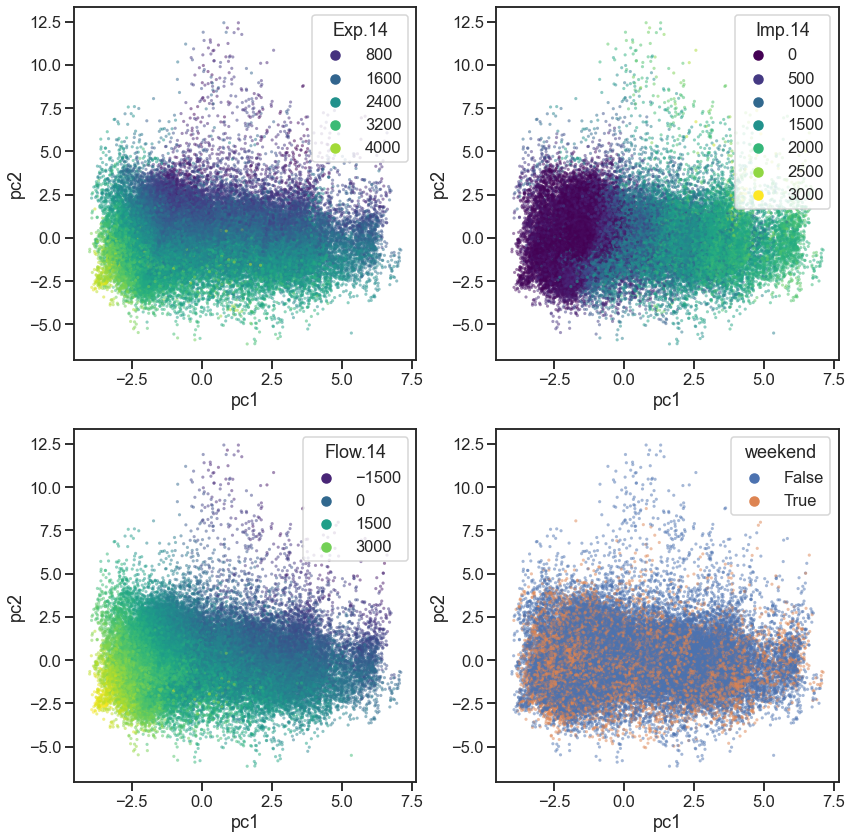

In [234]:
flow_pcs_df
fig, ax = plt.subplots(2,2, figsize=(12,12))
c = 'blue'
labr = flow_t.reset_index()
labr['weekend'] = labr['index'].dt.day_name().isin(['Saturday','Sunday'])

sns.scatterplot(ax=ax[0,0], data=flow_pcs_df, x='pc1', y='pc2', 
                alpha=0.5, s=10, linewidth=0.0, color=c,
                hue=labr['Exp.14'], palette='viridis'
                )
sns.scatterplot(ax=ax[0,1], data=flow_pcs_df, x='pc1', y='pc2', 
                alpha=0.5, s=10, linewidth=0.0, color=c,
                hue=labr['Imp.14'], palette='viridis'
                )
sns.scatterplot(ax=ax[1,0], data=flow_pcs_df, x='pc1', y='pc2', 
                alpha=0.5, s=10, linewidth=0.0, color=c,
                hue=labr['Flow.14'], palette='viridis'
                )
sns.scatterplot(ax=ax[1,1], data=flow_pcs_df, x='pc1', y='pc2', 
                alpha=0.5, s=10, linewidth=0.0, color=c,
                hue=labr['weekend']
                )
plt.tight_layout()

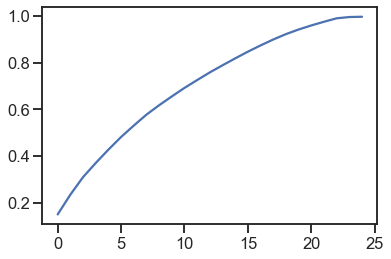

In [197]:
variance = pca.explained_variance_ratio_.cumsum()
plt.plot(np.arange(0,25), variance[:25])

### Weather Data

In [9]:
weather = []
for x in range(2018,2024):
    print(x)
    weather_x = pd.read_csv('station_data_daily/en_climate_daily_ON_{}_pearson.csv'.format(x), index_col=4
                         )   
    weather_x.index = pd.DatetimeIndex(weather_x.index)
    weather.append(weather_x)

weather_t = pd.concat(weather)
weather_t = weather_t.drop(['Station Name', 'Climate ID', 'Data Quality', 'Max Temp Flag',
                            'Min Temp Flag', 'Mean Temp Flag', 'Heat Deg Days Flag','Cool Deg Days Flag',
                            'Total Rain Flag','Total Snow Flag','Total Precip Flag', 'Snow on Grnd Flag',
                            'Dir of Max Gust Flag','Spd of Max Gust Flag', 'Snow on Grnd (cm)'],axis=1)
print(weather_t.shape)
print(weather_x.columns)
weather_t.head()

2018
2019
2020
2021
2022
2023
(2191, 15)
Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year',
       'Month', 'Day', 'Data Quality', 'Max Temp (°C)', 'Max Temp Flag',
       'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)', 'Mean Temp Flag',
       'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)',
       'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag',
       'Total Snow (cm)', 'Total Snow Flag', 'Total Precip (mm)',
       'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag',
       'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag',
       'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag'],
      dtype='object')


,Longitude (x),Latitude (y),Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,,,,
2018-01-01,-79.63,43.68,2018,1,1,-8.7,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54
2018-01-02,-79.63,43.68,2018,1,2,-7.8,-13.1,-10.5,28.5,0.0,0.0,1.0,1.0,24.0,59
2018-01-03,-79.63,43.68,2018,1,3,-6.3,-13.5,-9.9,27.9,0.0,0.0,0.0,0.0,22.0,44
2018-01-04,-79.63,43.68,2018,1,4,-8.9,-20.5,-14.7,32.7,0.0,0.0,0.0,0.0,32.0,65
2018-01-05,-79.63,43.68,2018,1,5,-15.0,-23.0,-19.0,37.0,0.0,0.0,0.0,0.0,31.0,50


In [12]:
weather_t.isnull().sum(axis=0)

Longitude (x)                  0
Latitude (y)                   0
Year                           0
Month                          0
Day                            0
Max Temp (°C)                 60
Min Temp (°C)                 62
Mean Temp (°C)                62
Heat Deg Days (°C)            62
Cool Deg Days (°C)            62
Total Rain (mm)               58
Total Snow (cm)               56
Total Precip (mm)             50
Dir of Max Gust (10s deg)    425
Spd of Max Gust (km/h)       383
dtype: int64

In [285]:
# exclude total columns at end
weather_scaled = StandardScaler().fit_transform(weather_t.iloc[:,2:].drop(['Spd of Max Gust (km/h)','Dir of Max Gust (10s deg)'], axis=1).dropna())
pca = PCA()
weather_pcs = pca.fit_transform(weather_scaled)

# Store
cols= ['pc{}'.format(i) for i in range(1,weather_scaled.shape[1]+1)]
weather_pcs_df = pd.DataFrame(data=weather_pcs,
                            columns=cols)

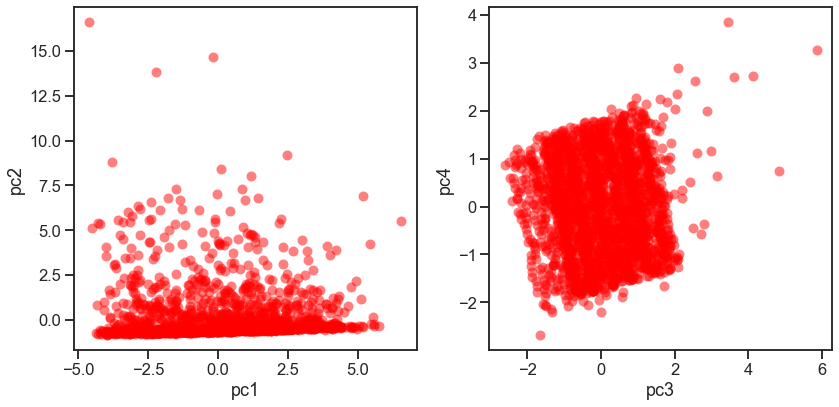

In [286]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
c = 'red'
sns.scatterplot(ax=ax[0], data=weather_pcs_df, x='pc1', y='pc2', 
                alpha=0.5, s=100, linewidth=0.0, color=c,
                #hue=flow_t.reset_index()['Imp.14']
                )
sns.scatterplot(ax=ax[1], data=weather_pcs_df, x='pc3', y='pc4', 
                alpha=0.5, s=100, linewidth=0.0, color=c
                )
plt.tight_layout()

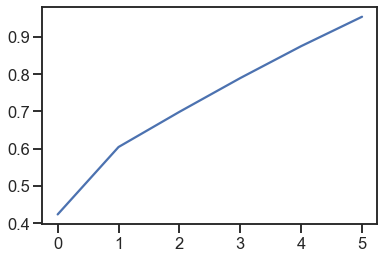

In [287]:
variance = pca.explained_variance_ratio_.cumsum()
plt.plot(np.arange(0,6), variance[:6])

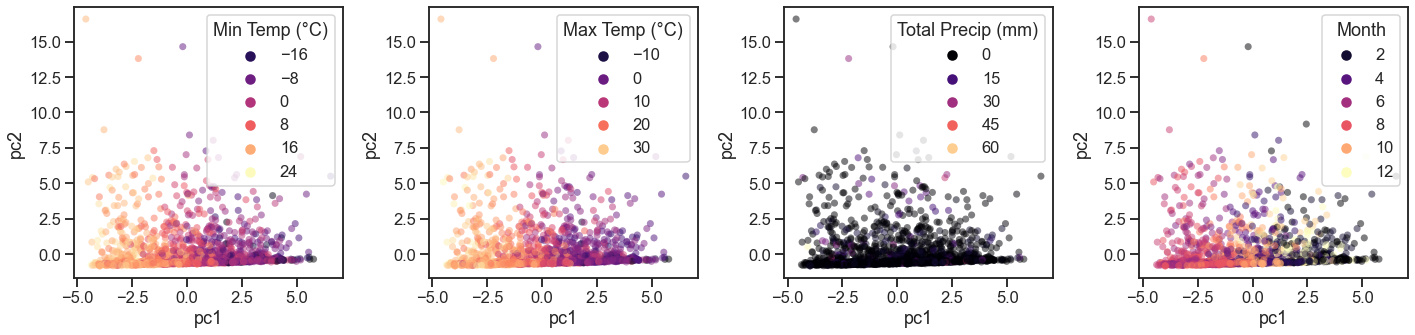

In [289]:
flow_pcs_df
fig, ax = plt.subplots(1,4, figsize=(20,5))
c = 'blue'
sr = 50
labr = weather_t.reset_index()
#labr['weekend'] = labr['index'].dt.day_name().isin(['Saturday','Sunday'])

sns.scatterplot(ax=ax[0], data=weather_pcs_df, x='pc1', y='pc2', 
                alpha=0.5, s=sr, linewidth=0.0, color=c,
                hue=labr['Min Temp (°C)'], palette='magma'
                )
sns.scatterplot(ax=ax[1], data=weather_pcs_df, x='pc1', y='pc2', 
                alpha=0.5, s=sr, linewidth=0.0, color=c,
                hue=labr['Max Temp (°C)'], palette='magma'
                )
sns.scatterplot(ax=ax[2], data=weather_pcs_df, x='pc1', y='pc2', 
                alpha=0.5, s=sr, linewidth=0.0, color=c,
                hue=labr['Total Precip (mm)'], palette='magma'
                )
sns.scatterplot(ax=ax[3], data=weather_pcs_df, x='pc1', y='pc2', 
                alpha=0.5, s=sr, linewidth=0.0, color=c,
                hue=labr['Month'], palette='magma'
                )
plt.tight_layout()

## Organize and train-test split
Combine all of the data by date, impute, clean, train-test split using a time-series splitting technique (date before X, date after X)

Price data is all good. This is our target variable. Ontario's projection is missing values, which is okay. <br>
We can actually use this pre-dispatch to see if our model is better or worse than historical predictions by the government. Keep the operating reserve as it could be useful!

In [22]:
print(price_t.isnull().sum(axis=0))

price_t = price_t.rename(columns={'HOEP':'hourly_price',
                                  'OR 10 Min Sync':'or_10s',
                                  'OR 10 Min non-sync':'or_10ns',
                                  'OR 30 Min':'or_30'})
price_xy = price_t[['hourly_price','or_10s','or_10ns','or_30']]

Hour                    0
HOEP                    0
Hour 1 Predispatch    122
Hour 2 Predispatch    122
Hour 3 Predispatch    122
OR 10 Min Sync          0
OR 10 Min non-sync      0
OR 30 Min               0
dtype: int64


little cleaning to be done on demand

In [27]:
print(demand_t.isnull().sum(axis=0))
demand_xy = demand_t

Hour              0
Market Demand     0
Ontario Demand    0
dtype: int64


little cleaning to be done on flows

In [30]:
print(flow_t.isnull().sum(axis=0))
flow_xy = flow_t.drop('Hour',axis=1)

Hour       0
Imp        0
Exp        0
Flow       0
Imp.1      0
Exp.1      0
Flow.1     0
Imp.2      0
Exp.2      0
Flow.2     0
Imp.3      0
Exp.3      0
Flow.3     0
Imp.4      0
Exp.4      0
Flow.4     0
Imp.5      0
Exp.5      0
Flow.5     0
Imp.6      0
Exp.6      0
Flow.6     0
Imp.7      0
Exp.7      0
Flow.7     0
Imp.8      0
Exp.8      0
Flow.8     0
Imp.9      0
Exp.9      0
Flow.9     0
Imp.10     0
Exp.10     0
Flow.10    0
Imp.11     0
Exp.11     0
Flow.11    0
Imp.12     0
Exp.12     0
Flow.12    0
Imp.13     0
Exp.13     0
Flow.13    0
Imp.14     0
Exp.14     0
Flow.14    0
dtype: int64


weather imputation tasks:
- limit to the price range.
- convert max gust to integer values.
- input temperatures and HDD/CDD using the mean value for the month.
- input rain, snow using total precip - other if possible, assume zero if not.
- input wind direction and speed using K-NN imputation (as we don't have good priors on these values)

In [48]:
# fill the last day with the day before: the weather was basically the same:
weather_t.loc[datetime(2023,11,20,0)] = weather_t.loc[datetime(2023,11,19,0)]

# get only the range for which we have price data
weather_t = weather_t[datetime(2018,1,1,0):datetime(2023,11,20,0)]

print(weather_t.isnull().sum(axis=0))

Longitude (x)                  0
Latitude (y)                   0
Year                           0
Month                          0
Day                            0
Max Temp (°C)                 18
Min Temp (°C)                 20
Mean Temp (°C)                20
Heat Deg Days (°C)            20
Cool Deg Days (°C)            20
Total Rain (mm)               16
Total Snow (cm)               14
Total Precip (mm)              8
Dir of Max Gust (10s deg)    383
Spd of Max Gust (km/h)       341
dtype: int64


In [54]:
weather_t[weather_t.isnull().any(axis=1)]#[datetime(2018,1,1,0):datetime(2023,11,20,0)]

,Longitude (x),Latitude (y),Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,,,,
2018-01-10,-79.63,43.68,2018,1,10,6.6,-4.9,0.9,17.1,0.0,2.6,0.0,2.6,NaN,<31
2018-01-16,-79.63,43.68,2018,1,16,-3.1,-10.3,-6.7,24.7,0.0,0.0,1.6,1.4,NaN,<31
2018-01-25,-79.63,43.68,2018,1,25,-2.5,-11.2,-6.9,24.9,0.0,0.0,0.0,0.0,NaN,<31
2018-02-09,-79.63,43.68,2018,2,9,-5.3,-10.9,-8.1,26.1,0.0,0.0,6.8,6.0,NaN,<31
2018-02-10,-79.63,43.68,2018,2,10,-4.4,-6.7,-5.6,23.6,0.0,0.0,6.4,5.6,NaN,<31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-23,-79.63,43.68,2023,10,23,14.2,-0.2,7.0,11.0,0.0,0.0,0.0,0.0,NaN,NaN
2023-11-05,-79.63,43.68,2023,11,5,10.4,2.1,6.3,11.7,0.0,0.0,0.0,0.0,NaN,NaN
2023-11-11,-79.63,43.68,2023,11,11,3.6,-0.4,1.6,16.4,0.0,0.0,0.0,0.0,NaN,NaN
